In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import torch
from sqnet import SQNet, jacobian, hessian
import numpy as np
from utils import solve_crocoddyl, random_array, griddata
from data import crocoddyl_gradient
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
net = torch.load('fnet.pth')

In [4]:
def network_gradient(net, xtest):
    cost = net(torch.tensor(xtest, dtype=torch.float32)).detach().numpy().reshape(-1,1)
    
    true_gradient      = []
    approx_hessian     = []
    true_hessian       = []

    states = torch.tensor(xtest, dtype=torch.float32)
    
    for state in states:
        
        state.requires_grad = True
        
        # True gradient
        grad = jacobian(net(state), state)
        true_gradient.append(np.linalg.norm(grad.detach().numpy()))
        #print(grad)
        
        # True Hessian
        _hessian = hessian(net(state), state).detach().numpy()
        true_hessian.append(np.linalg.norm(_hessian))
        #print(_hessian)
        
        # Estimating from Jacobian
        newton = grad.T @ grad
        newton_hessian = newton.detach().numpy()
        approx_hessian.append(np.linalg.norm(newton_hessian))

        
    true_gradient    =  np.array(true_gradient).reshape(-1, 1)
    true_hessian     =  np.array(true_hessian).reshape(-1,1)
    approx_hessian   =  np.array(approx_hessian).reshape(-1, 1)
    
    return cost, true_gradient, true_hessian, approx_hessian

In [13]:
# 1d case

x = 0.99
y = np.linspace(-1., 1., 100)
xtest = np.array([ [x,x2, 0.] for x2 in y ])


In [14]:
cost_pred, net_gradient, net_hessian, net_approx_hessian = network_gradient(net, xtest)

cost, vx, vxx = crocoddyl_gradient(xtest)

<Figure size 432x288 with 0 Axes>

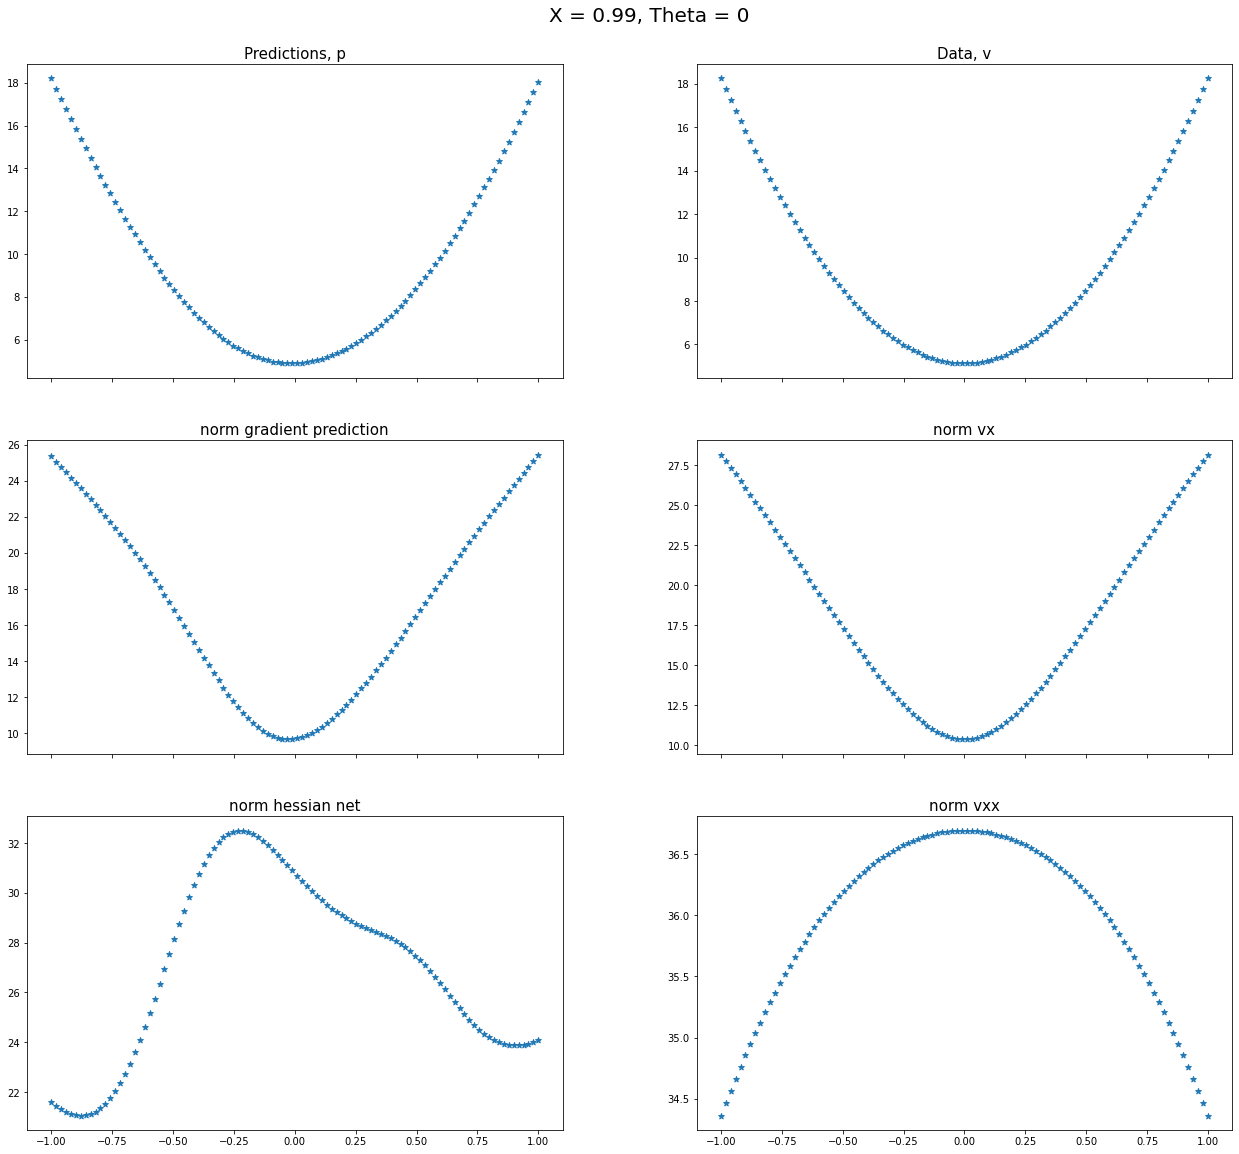

In [16]:
 plt.clf()
    
# Make the figure:

fig, axs = plt.subplots(3, 2, figsize=(18, 20), sharex=True, )
fig.suptitle("X = 0.99, Theta = 0", fontsize = 20)
fig.subplots_adjust(left=0.02, bottom=0.2, right=0.95, top=0.94, wspace=0.25)

# Plot prediction, cost
im1 = axs[0, 0].scatter(xtest[:,1], y = cost_pred, marker = "*")
im2 = axs[0, 1].scatter(xtest[:,1], y = cost, marker = "*")

im3 = axs[1, 0].scatter(xtest[:,1], y = net_gradient, marker = "*")
im4 = axs[1, 1].scatter(xtest[:,1], y = vx, marker = "*")

im5 = axs[2, 0].scatter(xtest[:,1], y = net_hessian, marker = "*")
im6 = axs[2, 1].scatter(xtest[:,1], y = vxx, marker = "*")


axs[0, 0].set_title("Predictions, p", fontsize  = 15)
axs[0, 1].set_title("Data, v", fontsize  = 15)
axs[1, 0].set_title("norm gradient prediction", fontsize  = 15)
axs[1, 1].set_title("norm vx", fontsize  = 15)
axs[2, 0].set_title("norm hessian net", fontsize  = 15)
axs[2, 1].set_title("norm vxx", fontsize  = 15)
plt.savefig("1dcase.png")